In [1]:
from lmfit import Model
from scipy.cluster.hierarchy import dendrogram, linkage

# read data

In [2]:
ls hG*/*coutt*

hG01-20umAP-120h-ChiSB43/SvdB13a1-1-Tomo-120hAA-hGstrlds10-19052018-ChiSB43_cbc_trimmed_bwa_filtered.coutt.tsv
hG01-20umAP-120h-ChiSB43/SvdB13a1-1-Tomo-120hAA-hGstrlds10-19052018-ChiSB43_cbc_trimmed_star_filtered.coutt.tsv
hG02-20umAP-120h-ChiSB43/SvdB13a1-2-Tomo-120hAA-hGstrlds79-19052018-ChiSB43_cbc_trimmed_bwa_filtered.coutt.tsv
hG02-20umAP-120h-ChiSB43/SvdB13a1-2-Tomo-120hAA-hGstrlds79-19052018-ChiSB43_cbc_trimmed_star_filtered.coutt.tsv
hG03-20umAP-72h-Chi/SvdB13a1-3-Tomo-72hAA-hGstrlds43-56-17052018-Chi_cbc_trimmed_bwa_filtered.coutt.tsv
hG03-20umAP-72h-Chi/SvdB13a1-3-Tomo-72hAA-hGstrlds43-56-17052018-Chi_cbc_trimmed_star_filtered.coutt.tsv
hG04-20umAP-72h-Chi/SvdB13a1-3-Tomo-72hAA-hGstrlds43-56-17052018-Chi_cbc_trimmed_bwa_filtered.coutt.tsv
hG04-20umAP-72h-Chi/SvdB13a1-3-Tomo-72hAA-hGstrlds43-56-17052018-Chi_cbc_trimmed_star_filtered.coutt.tsv


In [3]:
chi1 = read_csv('hG03-20umAP-72h-Chi/SvdB13a1-3-Tomo-72hAA-hGstrlds43-56-17052018-Chi_cbc_trimmed_bwa_filtered.coutt.tsv', sep = '\t', index_col=0)
chi2 = read_csv('hG04-20umAP-72h-Chi/SvdB13a1-3-Tomo-72hAA-hGstrlds43-56-17052018-Chi_cbc_trimmed_bwa_filtered.coutt.tsv', sep = '\t', index_col=0)

In [4]:
sb1 = read_csv('hG01-20umAP-120h-ChiSB43/SvdB13a1-1-Tomo-120hAA-hGstrlds10-19052018-ChiSB43_cbc_trimmed_bwa_filtered.coutt.tsv', sep = '\t', index_col=0)
sb2 = read_csv('hG02-20umAP-120h-ChiSB43/SvdB13a1-2-Tomo-120hAA-hGstrlds79-19052018-ChiSB43_cbc_trimmed_bwa_filtered.coutt.tsv', sep = '\t', index_col=0)

# ERCC comercial data

In [5]:
erccdf = read_csv('/Users/anna/Dropbox/gastruloids/data/analysis-notebooks/ERCC_comercial.tsv', sep = '\t', index_col=0)

In [6]:
erccdf.head()

ERCC ID subgroup  concentration in Mix 1 (attomoles/ul)  \
Re-sort ID                                                               
1           ERCC-00130        A                               30000.00   
2           ERCC-00004        A                                7500.00   
3           ERCC-00136        A                                1875.00   
4           ERCC-00108        A                                 937.50   
5           ERCC-00116        A                                 468.75   

            concentration in Mix 2 (attomoles/ul)  expected fold-change ratio  \
Re-sort ID                                                                      
1                                       7500.0000                         4.0   
2                                       1875.0000                         4.0   
3                                        468.7500                         4.0   
4                                        234.3750                         4.0   
5                                        117.1875                         4.0   

            log2(Mix 1/Mix 2)  
Re-sort ID                     
1                         2.0  
2                         2.0  
3                         2.0  
4                         2.0  
5                         2.0

In [7]:
erccdf = erccdf.set_index('ERCC ID')

In [8]:
erccdf.head()

subgroup  concentration in Mix 1 (attomoles/ul)  \
ERCC ID                                                      
ERCC-00130        A                               30000.00   
ERCC-00004        A                                7500.00   
ERCC-00136        A                                1875.00   
ERCC-00108        A                                 937.50   
ERCC-00116        A                                 468.75   

            concentration in Mix 2 (attomoles/ul)  expected fold-change ratio  \
ERCC ID                                                                         
ERCC-00130                              7500.0000                         4.0   
ERCC-00004                              1875.0000                         4.0   
ERCC-00136                               468.7500                         4.0   
ERCC-00108                               234.3750                         4.0   
ERCC-00116                               117.1875                         4.0   

            log2(Mix 1/Mix 2)  
ERCC ID                        
ERCC-00130                2.0  
ERCC-00004                2.0  
ERCC-00136                2.0  
ERCC-00108                2.0  
ERCC-00116                2.0

# removal of MT genes & normalization

In [9]:
# noMT
fchi1 = chi1.loc[[idx for idx in chi1.index if 'chrM' not in idx]]
fchi2 = chi2.loc[[idx for idx in chi2.index if 'chrM' not in idx]]
fsb1 = sb1.loc[[idx for idx in sb1.index if 'chrM' not in idx]]
fsb2 = sb2.loc[[idx for idx in sb2.index if 'chrM' not in idx]]

## chi1, try spike-in normalization

In [10]:
ercc = [idx for idx in fchi1.index if 'ERCC' in idx]
mdf = erccdf.loc[ercc, ['concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)']].merge(fchi1.loc[ercc], how = 'left', left_index = True, right_index = True)

In [11]:
len(fchi1.columns)

24

In [12]:
def spikeinlinear(x,b):
    return x+b

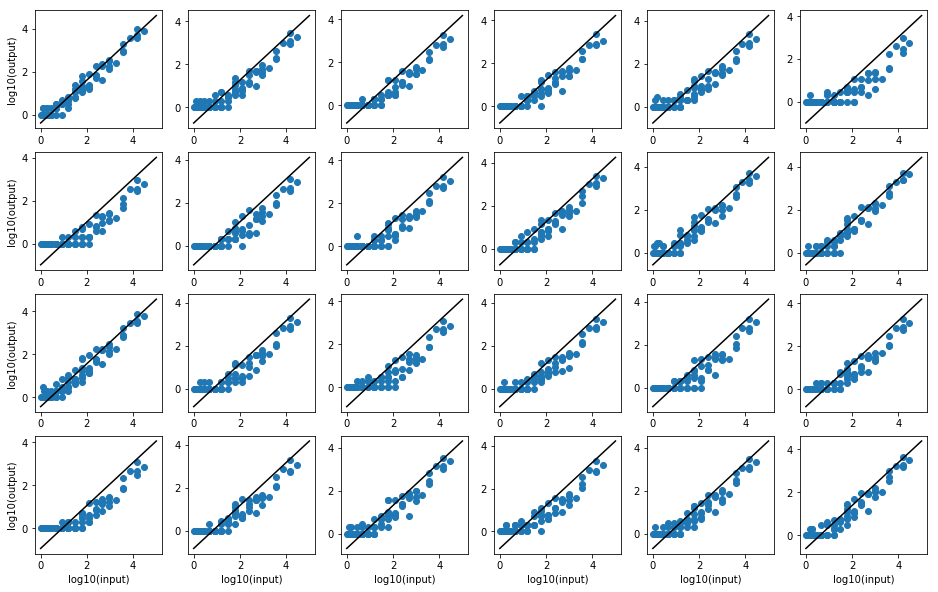

In [13]:
plt.figure(figsize=(10*1.6,10))
fitdf = pd.Series(0, index = fchi1.columns)
for i, c in enumerate(fchi1.columns):
    lmodel = Model(spikeinlinear)
    lfit = lmodel.fit(np.log10(mdf[c]+1), x = np.log10(mdf['concentration in Mix 1 (attomoles/ul)']+1), b = 0.1)
    plt.subplot(4,6,i+1)
    plt.scatter(np.log10(mdf['concentration in Mix 1 (attomoles/ul)']+1), np.log10(mdf[c]+1))
    xra = np.linspace(0,5,100)
    plt.plot(xra, spikeinlinear(xra, lfit.params['b'].value), c = 'k')
    fitdf.loc[c] = lfit.params['b'].value
    if i+1 in [1,7,13,19]:
        plt.ylabel('log10(output)')
    if i+1 in [19,20,21,22,23,24]:
        plt.xlabel('log10(input)')
plt.show()

In [14]:
chi1.head()

24  25  26  27  28  29  30  31  32   33 ...  38  39  40  \
GENEID                                                        ...               
0610007P14Rik__chr12   4   1   2   2   0   0   0   6   7   12 ...   1   1   1   
0610009B22Rik__chr11   2   1   1   1   1   2   0   0   3    2 ...   1   0   0   
0610009D07Rik__chr12  38  19  31  26  34  51   9  29  83  102 ...  15  21  23   
0610009O20Rik__chr18   0   0   0   0   0   0   0   0   0    0 ...   0   0   0   
0610010F05Rik__chr11   1   1   2   0   0   0   0   1   1    2 ...   1   0   0   

                      41  42  43   44  45  46  47  
GENEID                                             
0610007P14Rik__chr12   3   1   7    6   1   0   6  
0610009B22Rik__chr11   0   0   2    2   0   1   2  
0610009D07Rik__chr12  33  27  67  125  30   5  31  
0610009O20Rik__chr18   0   0   0    0   0   0   0  
0610010F05Rik__chr11   0   0   6    5   0   0   1  

[5 rows x 24 columns]

In [15]:
10**fitdf

24    0.409780
25    0.188623
26    0.146245
27    0.165403
28    0.178806
29    0.104750
30    0.104648
31    0.128417
32    0.139601
33    0.179329
34    0.280277
35    0.269910
36    0.358074
37    0.145576
38    0.122719
39    0.148931
40    0.134306
41    0.151708
42    0.112849
43    0.152251
44    0.209439
45    0.162595
46    0.203474
47    0.244225
dtype: float64

In [16]:
snchi1 = chi1*10**-fitdf

In [17]:
g_ppia = 'Ppia__chr11'
g_gapdh = 'Gapdh__chr6'

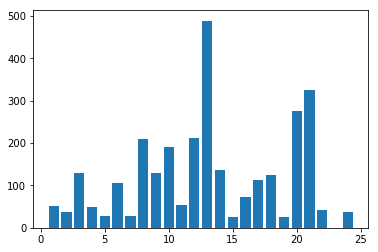

In [18]:
plt.bar(range(1,1+len(snchi1.columns)), snchi1.loc[g_ppia])
plt.show()

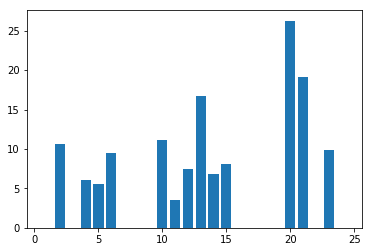

In [19]:
plt.bar(range(1,1+len(snchi1.columns)), snchi1.loc[g_gapdh])
plt.show()

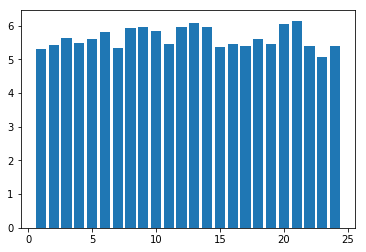

In [20]:
plt.bar(range(1,1+len(snchi1.columns)), np.log10(snchi1.sum()))
plt.show()

this looks bad..

## general noMT, normalization, HK genes

In [21]:
ffchi1 = fchi1.loc[[idx for idx in fchi1.index if 'ERCC' not in idx]]
ffchi2 = fchi2.loc[[idx for idx in fchi2.index if 'ERCC' not in idx]]
ffsb1 = fsb1.loc[[idx for idx in fsb1.index if 'ERCC' not in idx]]
ffsb2 = fsb2.loc[[idx for idx in fsb2.index if 'ERCC' not in idx]]

In [22]:
nffchi1 = ffchi1.sum().median()*ffchi1/ffchi1.sum()
nffchi2 = ffchi2.sum().median()*ffchi2/ffchi2.sum()
nffsb1 = ffsb1.sum().median()*ffsb1/ffsb1.sum()
nffsb2 = ffsb2.sum().median()*ffsb2/ffsb2.sum()

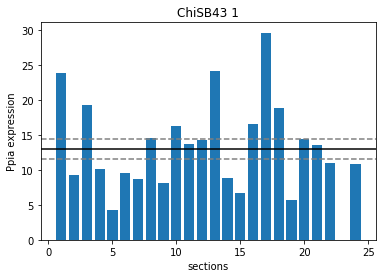

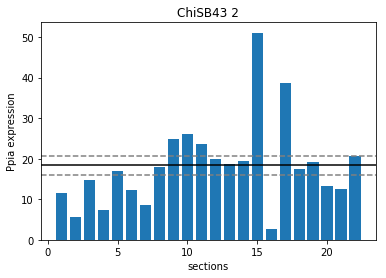

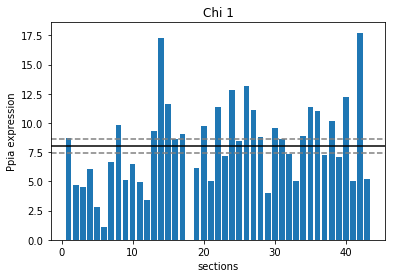

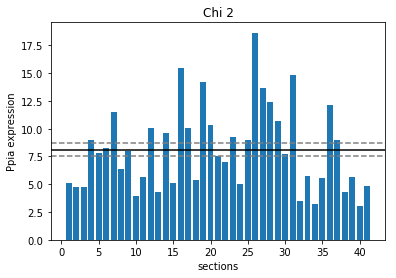

In [23]:
labels = ['ChiSB43 1', 'ChiSB43 2', 'Chi 1', 'Chi 2']
for i, df in enumerate([nffchi1, nffchi2, nffsb1, nffsb2]):
    plt.bar(range(1,1+len(df.columns)), df.loc[g_ppia])
    plt.axhline(df.loc[g_ppia].mean(), c = 'k')
    plt.axhline(df.loc[g_ppia].mean()+df.loc[g_ppia].std()/np.sqrt(len(df.columns)-1), c = 'gray', ls = '--')
    plt.axhline(df.loc[g_ppia].mean()-df.loc[g_ppia].std()/np.sqrt(len(df.columns)-1), c = 'gray', ls = '--')

    plt.xlabel('sections')
    plt.ylabel('Ppia expression')
    plt.title(labels[i])
    
    plt.savefig( '-'.join(labels[i].rsplit(' ')) + '_Ppia.pdf', bbox_inches = 'tight'  )
    
    plt.show()

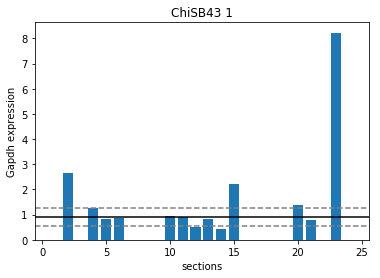

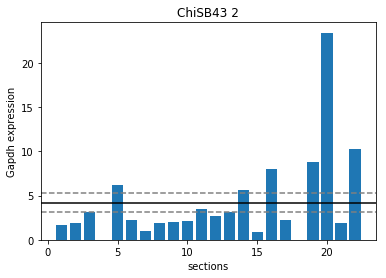

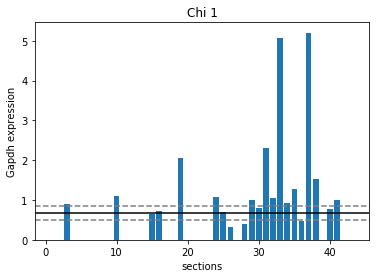

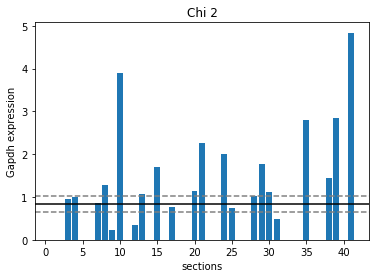

In [24]:
labels = ['ChiSB43 1', 'ChiSB43 2', 'Chi 1', 'Chi 2']
for i, df in enumerate([nffchi1, nffchi2, nffsb1, nffsb2]):
    plt.bar(range(1,1+len(df.columns)), df.loc[g_gapdh])
    plt.axhline(df.loc[g_gapdh].mean(), c = 'k')
    plt.axhline(df.loc[g_gapdh].mean()+df.loc[g_gapdh].std()/np.sqrt(len(df.columns)-1), c = 'gray', ls = '--')
    plt.axhline(df.loc[g_gapdh].mean()-df.loc[g_gapdh].std()/np.sqrt(len(df.columns)-1), c = 'gray', ls = '--')

    plt.xlabel('sections')
    plt.ylabel('Gapdh expression')
    plt.title(labels[i])
    
    plt.savefig( '-'.join(labels[i].rsplit(' ')) + '_Gapdh.pdf', bbox_inches = 'tight'  )
    
    plt.show()

# Heatmaps

In [25]:
def vargenes(df, n):
    df = df.loc[df.index[df.sum(axis=1)!=0]]
    cvdf = pd.DataFrame({'mu': df.mean(axis=1), 'var': df.var(axis=1)})
    cvdf['cv'] = np.sqrt(cvdf['var'])/cvdf['mu']
    cvdf['r'] = np.log10(cvdf['mu'])
    cvdf['s'] = np.log10(cvdf['cv'])
    a = -0.5; b = 0 # straight line for poisson cv
    cvdf['xmin'] = (a*cvdf['s']-a*b-cvdf['r'])/(a**2-1)
    cvdf['ymin'] = a*cvdf['xmin'] + b
    cvdf['dist'] = np.sqrt((cvdf['r']-cvdf['xmin'])**2+(cvdf['s']-cvdf['ymin'])**2)
    cvdf = cvdf.sort_values(by='dist', ascending = False)
    return cvdf#, cvdf.index[:n]

In [26]:
cvnffchi1df = vargenes(nffchi1, n = 500)
cvnffchi2df = vargenes(nffchi2, n = 500) 

cvnffsb1df = vargenes(nffsb1, n = 500) 
cvnffsb2df = vargenes(nffsb2, n = 500) 

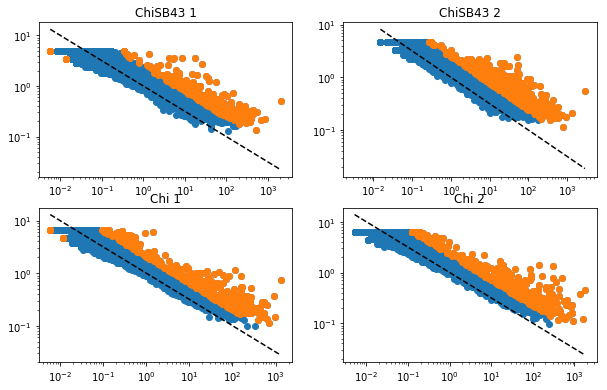

In [27]:
# all genes, normalized data, cv
plt.figure(figsize=(10,10/1.6))
for i, cvdf in enumerate([cvnffchi1df, cvnffchi2df, cvnffsb1df, cvnffsb2df]):
    plt.subplot(2,2,i+1)
    plt.scatter(cvdf['mu'], cvdf['cv'])
    plt.scatter(cvdf['mu'].iloc[:500], cvdf['cv'].iloc[:500])
    xra = np.linspace(cvdf['mu'].min(), cvdf['mu'].max(), 100)
    plt.plot(xra, 1./np.sqrt(xra), c = 'k', ls ='--')
    plt.title(labels[i])
    plt.loglog()
plt.show()

In [32]:
def hierarchicalClustering(df, ct = 100):
    Z = linkage(df, method='ward')
    dg = dendrogram(Z, no_labels=True, color_threshold=ct, orientation = 'left', no_plot = True)
    plt.show()
    return Z, dg

In [29]:
def relative(df):
    df = df.loc[df.index[df.sum(axis=1)!=0]]
    rdf = df.T
    rdf = rdf/rdf.sum()
    rdf = rdf.T
    return rdf

In [30]:
def zscore(df):
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

In [31]:
def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

In [34]:
rnffchi1 = zscore(nffchi1)
rnffchi2 = zscore(nffchi2)
rnffsb1 = zscore(nffsb1)
rnffsb2 = zscore(nffsb2)

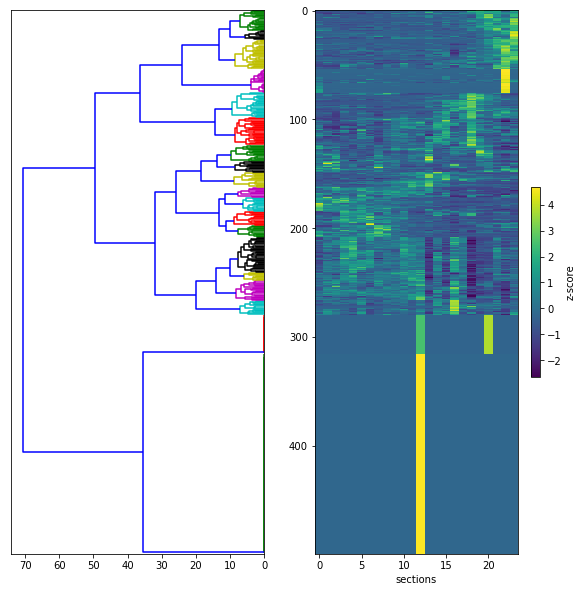

In [37]:
numgenes = 500

gschi1 = cvnffchi1df.sort_values(by='dist', ascending=False).index[:numgenes]
Zchi1, dgchi1 = hierarchicalClustering(rnffchi1.loc[gschi1], ct = 5)

plt.figure(figsize=(10,10))
plt.subplot(121)
dgchi1 = dendrogram(Zchi1, no_labels=True, color_threshold=10, orientation='left')
plt.subplot(122)
plt.imshow(rnffchi1.loc[gschi1[dgchi1['leaves'][::-1]]], aspect='auto')
plt.colorbar(shrink=.35, label = 'z-score', orientation = 'vertical')
plt.xlabel('sections')
plt.savefig('hG03-20umAP-72h-Chi/hclust/heatmap-chi1.pdf', bbox_anchor = 'tight')
plt.show()

In [34]:
clustersChi1 = getClusterByColor(dgchi1, gschi1)

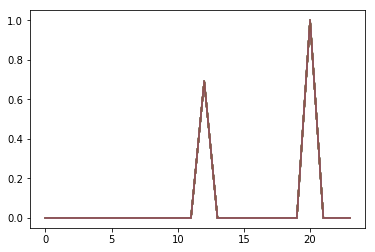

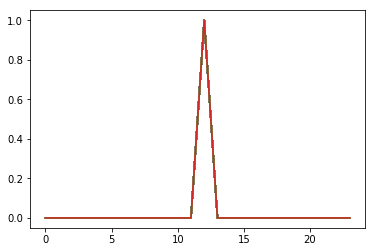

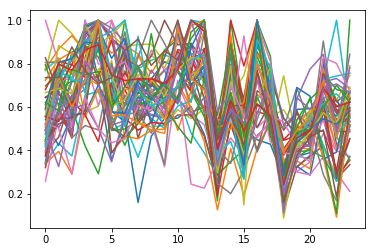

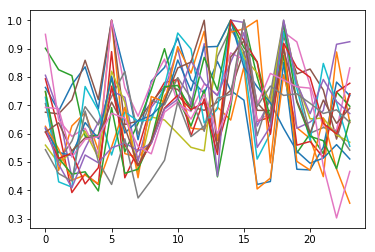

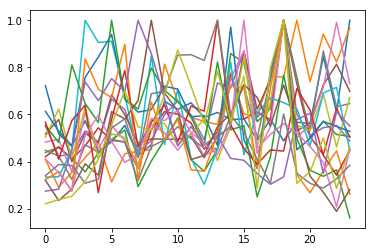

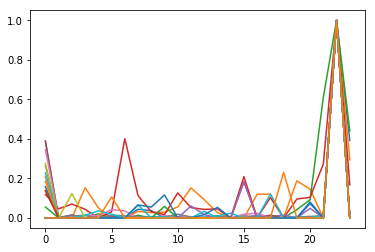

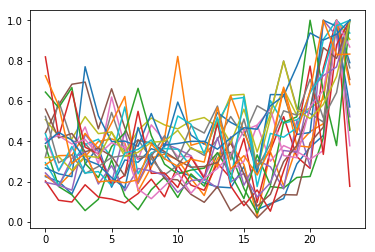

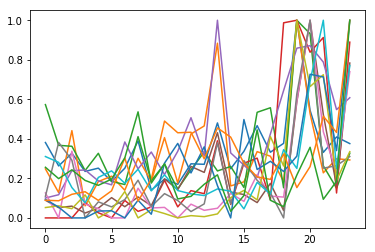

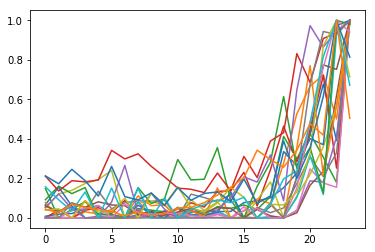

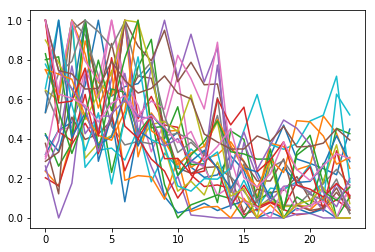

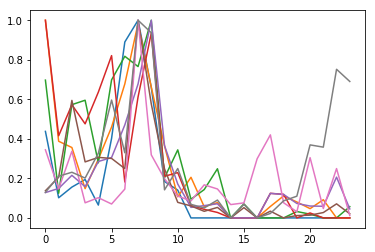

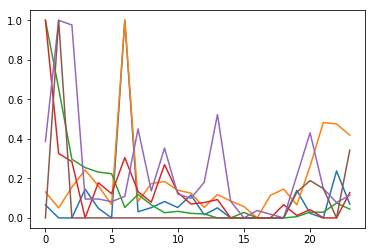

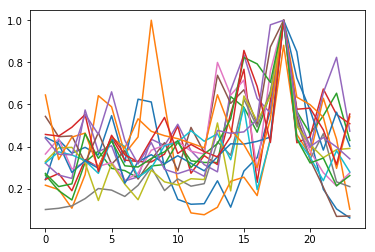

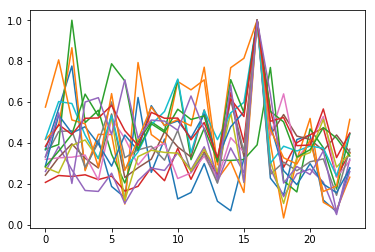

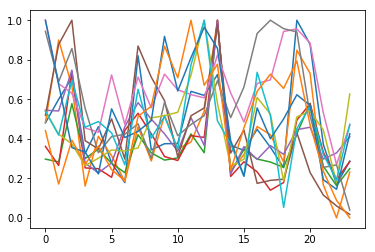

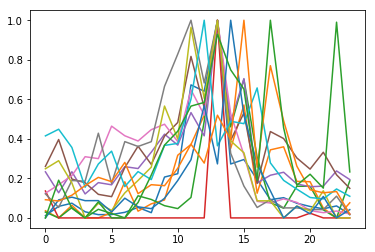

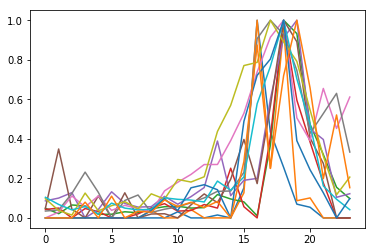

In [35]:
for cluster in clustersChi1:
    for g in clustersChi1[cluster]:
        plt.plot(range(len(rnffchi1.columns)), rnffchi1.loc[g])
    plt.savefig('hG03-20umAP-72h-Chi/hclust/hclust' + str(cluster).zfill(3) + '-chi1.pdf', bbox_anchor = 'tight')
    plt.show()
    plt.close()
    pd.Series(clustersChi1[cluster]).to_csv('hG03-20umAP-72h-Chi/hclust/hclust' + str(cluster).zfill(3) + '-chi1.txt')

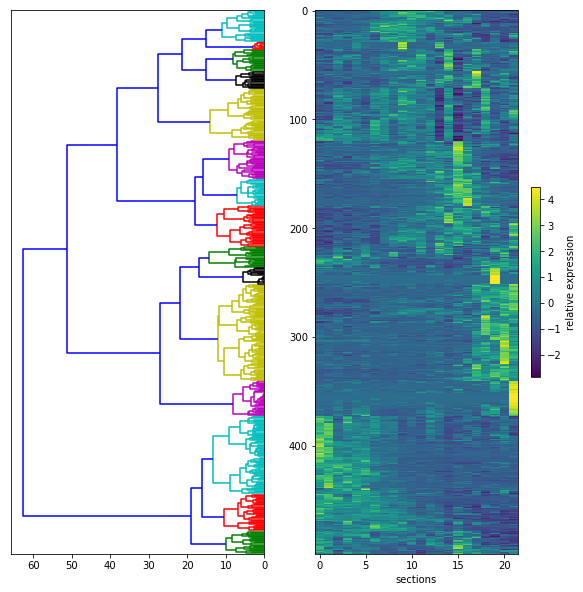

In [57]:
numgenes = 500

gschi2 = cvnffchi2df.sort_values(by='dist', ascending=False).index[:numgenes]
Zchi2, dgchi2 = hierarchicalClustering(rnffchi2.loc[gschi2], ct = 5)

plt.figure(figsize=(10,10))
plt.subplot(121)
dgchi2 = dendrogram(Zchi2, no_labels=True, color_threshold=15, orientation='left')
plt.subplot(122)
plt.imshow(rnffchi2.loc[gschi2[dgchi2['leaves']][::-1]], aspect='auto')
plt.colorbar(shrink=.35, label = 'relative expression', orientation = 'vertical')
plt.xlabel('sections')
plt.savefig('hG04-20umAP-72h-Chi/hclust/heatmap-chi2.pdf', bbox_anchor = 'tight')

plt.show()

In [50]:
cnt = Counter(list(gschi1)+list(gschi2))
gschi_ov = pd.Series([g for g in cnt if cnt[g]==2])

In [51]:
rnffchi_mdf = rnffchi1.merge(rnffchi2, how = 'outer', left_index = True, right_index = True)

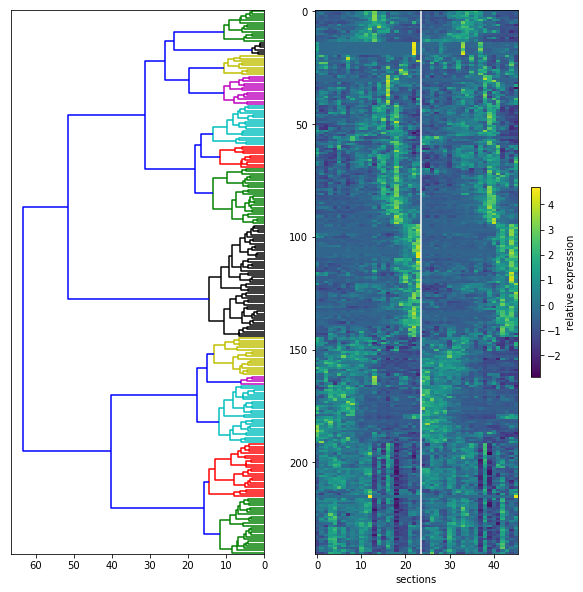

In [65]:
Zchi_m, dgchi_m = hierarchicalClustering(rnffchi_mdf.loc[gschi_ov], ct = 5)

plt.figure(figsize=(10,10))
plt.subplot(121)
dgchi_m = dendrogram(Zchi_m, no_labels=True, color_threshold=15, orientation='left')
plt.subplot(122)
plt.imshow(rnffchi_mdf.loc[gschi_ov[dgchi_m['leaves']][::-1]], aspect='auto')
plt.colorbar(shrink=.35, label = 'relative expression', orientation = 'vertical')
plt.xlabel('sections')
plt.axvline(len(rnffchi1.columns)-0.5, c = 'w')
plt.savefig('heatmap-chi-merged.pdf', bbox_anchor = 'tight')

plt.show()

In [66]:
clustersChi_m = getClusterByColor(dgchi_m, gschi_ov)

In [84]:
for cluster in clustersChi_m:
    pd.Series(clustersChi_m[cluster]).to_csv('heatmap-chi-merged_hclust' + str(cluster).zfill(3) + '.txt')

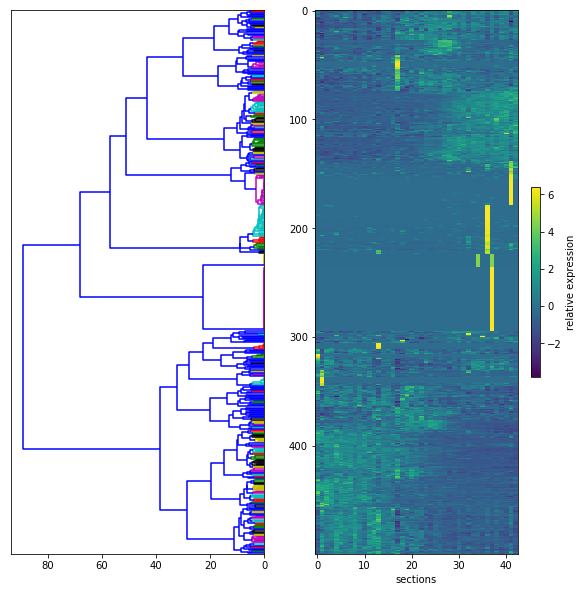

In [70]:
numgenes = 500

gssb1 = cvnffsb1df.sort_values(by='dist', ascending=False).index[:numgenes]
Zsb1, dgsb1 = hierarchicalClustering(rnffsb1.loc[gssb1])

plt.figure(figsize=(10,10))
plt.subplot(121)
dgsb1 = dendrogram(Zsb1, no_labels=True, color_threshold=5, orientation='left')
plt.subplot(122)
plt.imshow(rnffsb1.loc[gssb1[dgsb1['leaves']][::-1]], aspect='auto')
plt.colorbar(shrink=.35, label = 'relative expression', orientation = 'vertical')
plt.xlabel('sections')
plt.savefig('hG01-20umAP-120h-ChiSB43/hclust/heatmap-chisb43-1.pdf', bbox_anchor = 'tight')

plt.show()

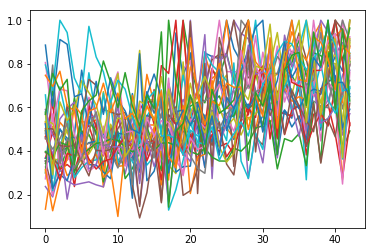

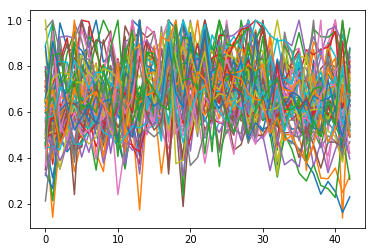

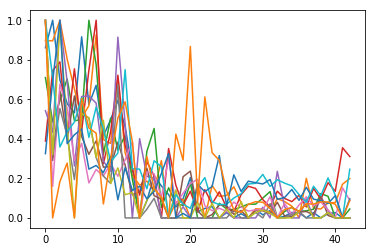

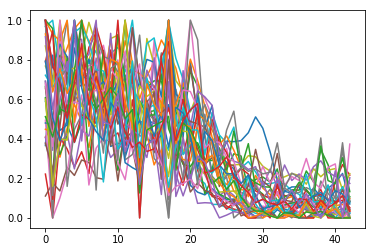

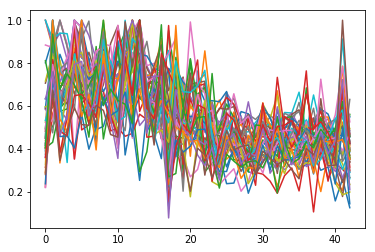

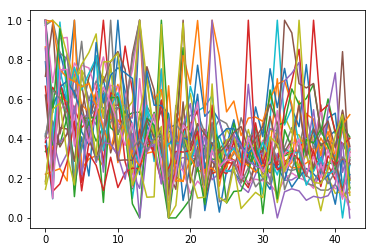

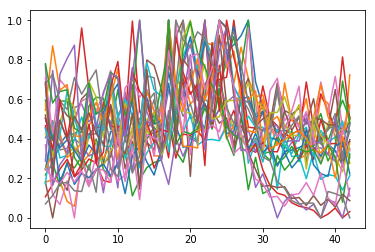

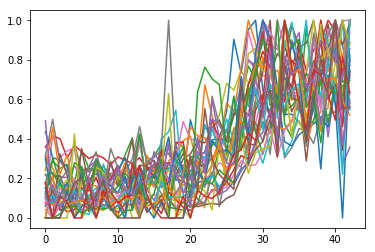

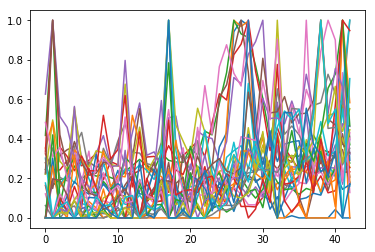

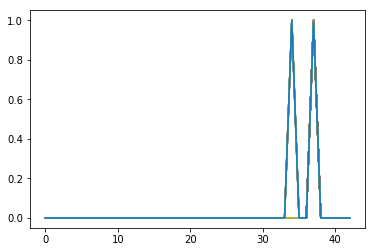

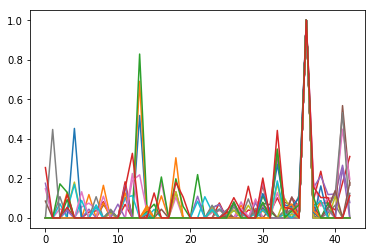

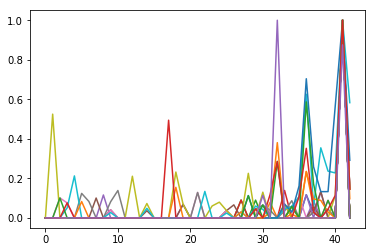

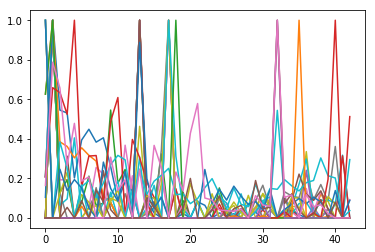

In [39]:
clustersSB1 = getClusterByColor(dgsb1, gssb1)

for cluster in clustersSB1:
    for g in clustersSB1[cluster]:
        plt.plot(range(len(rnffsb1.columns)), rnffsb1.loc[g])
    plt.savefig('hG01-20umAP-120h-ChiSB43/hclust/hclust' + str(cluster).zfill(3) + '-chiSB43-1.pdf', bbox_anchor = 'tight')
    plt.show()
    plt.close()
    pd.Series(clustersSB1[cluster]).to_csv('hG01-20umAP-120h-ChiSB43/hclust/hclust' + str(cluster).zfill(3) + '-chiSB43-1.txt')

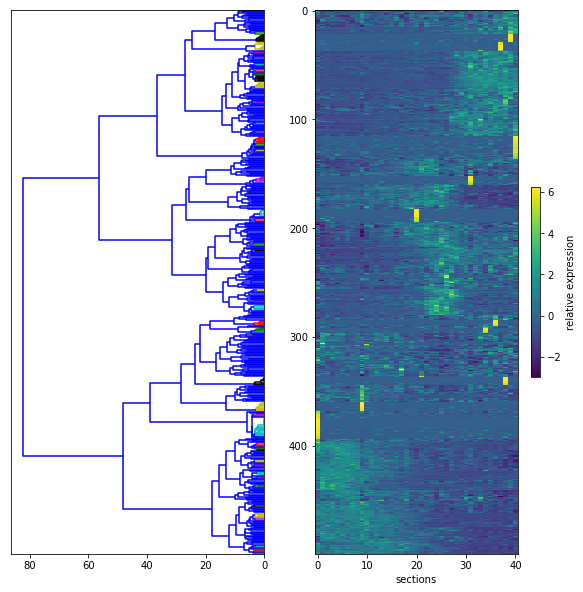

In [71]:
numgenes = 500

gssb2 = cvnffsb2df.sort_values(by='dist', ascending=False).index[:numgenes]
Zsb2, dgsb2 = hierarchicalClustering(rnffsb2.loc[gssb2])

plt.figure(figsize=(10,10))
plt.subplot(121)
dgsb2 = dendrogram(Zsb2, no_labels=True, color_threshold=3.5, orientation='left')
plt.subplot(122)
plt.imshow(rnffsb2.loc[gssb2[dgsb2['leaves']][::-1]], aspect='auto')
plt.colorbar(shrink=.35, label = 'relative expression', orientation = 'vertical')
plt.xlabel('sections')
plt.savefig('hG02-20umAP-120h-ChiSB43/hclust/heatmap-chisb43-2.pdf', bbox_anchor = 'tight')

plt.show()


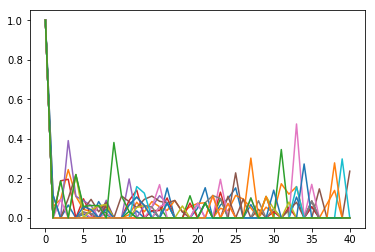

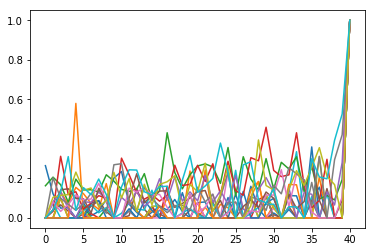

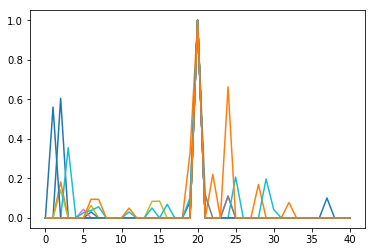

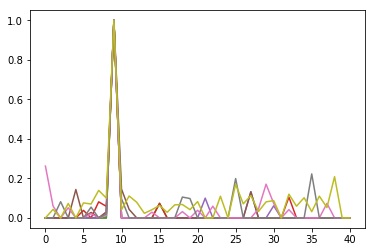

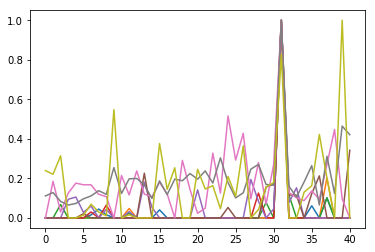

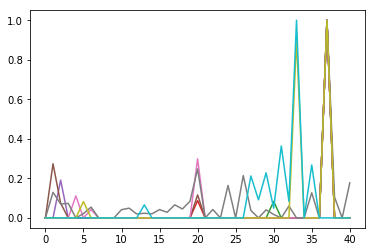

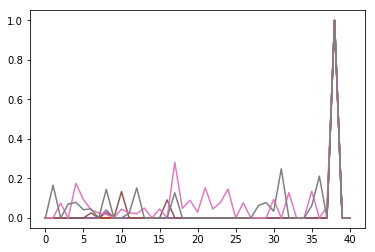

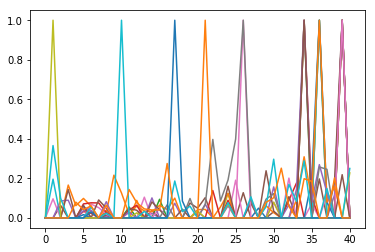

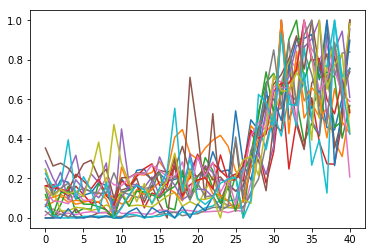

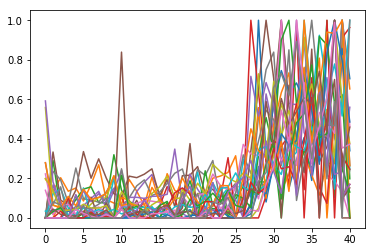

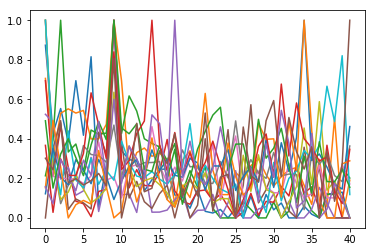

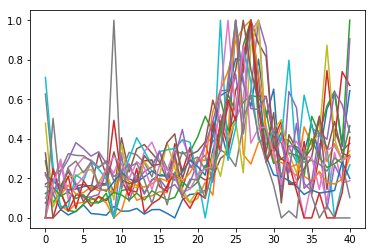

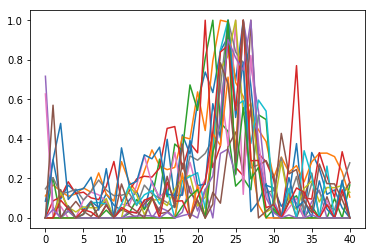

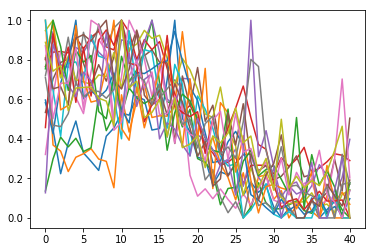

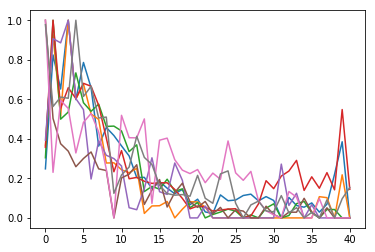

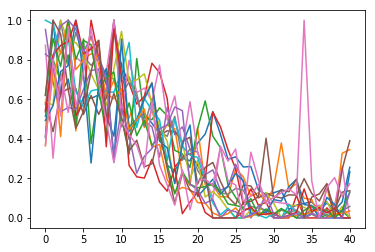

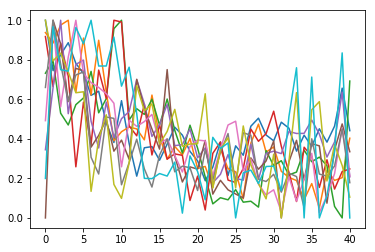

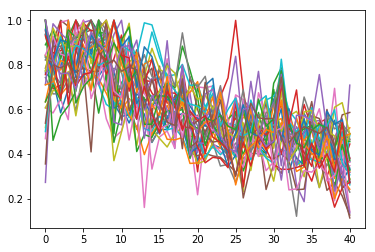

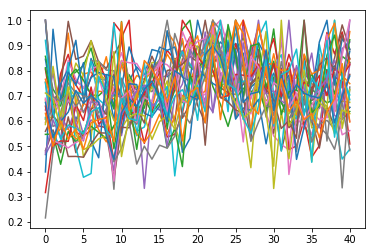

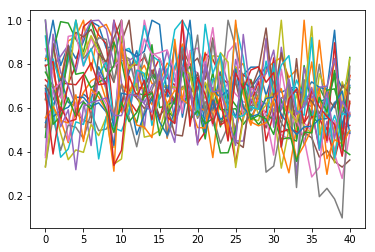

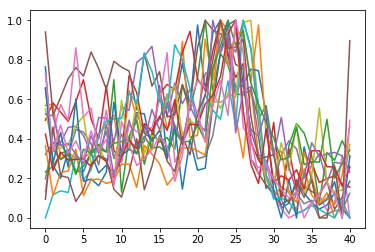

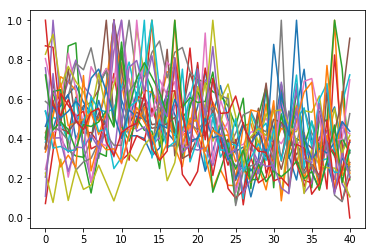

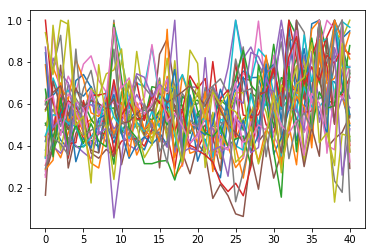

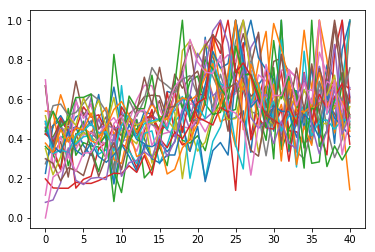

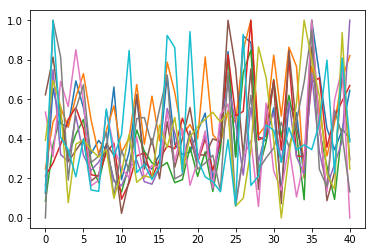

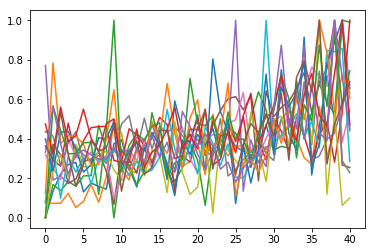

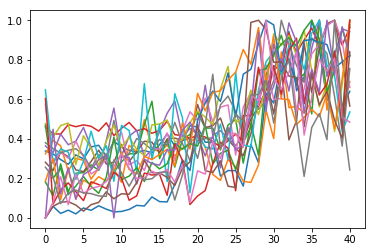

In [41]:
clustersSB2 = getClusterByColor(dgsb2, gssb2)

for cluster in clustersSB2:
    for g in clustersSB2[cluster]:
        plt.plot(range(len(rnffsb2.columns)), rnffsb2.loc[g])
    plt.savefig('hG02-20umAP-120h-ChiSB43/hclust/hclust' + str(cluster).zfill(3) + '-chiSB43-2.pdf', bbox_anchor = 'tight')
    plt.show()
    pd.Series(clustersSB2[cluster]).to_csv('hG02-20umAP-120h-ChiSB43/hclust/hclust' + str(cluster).zfill(3) + '-chiSB43-2.txt')

In [75]:
cnt = Counter(list(gssb1)+list(gssb2))
gssb_ov = pd.Series([g for g in cnt if cnt[g]==2])

In [74]:
rnffsb_mdf = rnffsb1.merge(rnffsb2, how = 'outer', left_index = True, right_index = True)

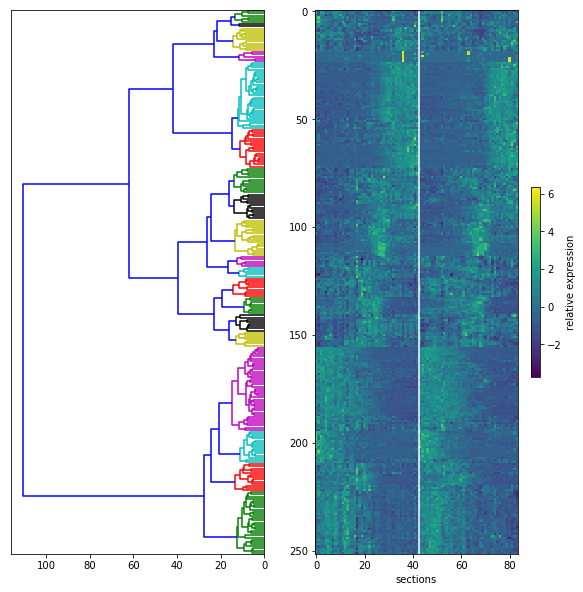

In [76]:
Zsb_m, dgsb_m = hierarchicalClustering(rnffsb_mdf.loc[gssb_ov], ct = 5)

plt.figure(figsize=(10,10))
plt.subplot(121)
dgsb_m = dendrogram(Zsb_m, no_labels=True, color_threshold=15, orientation='left')
plt.subplot(122)
plt.imshow(rnffsb_mdf.loc[gssb_ov[dgsb_m['leaves']][::-1]], aspect='auto')
plt.colorbar(shrink=.35, label = 'relative expression', orientation = 'vertical')
plt.xlabel('sections')
plt.axvline(len(rnffsb1.columns)-0.5, c = 'w')
plt.savefig('heatmap-chisb43-merged.pdf', bbox_anchor = 'tight')

plt.show()

In [81]:
clustersSB_m = getClusterByColor(dgsb_m, gssb_ov)

In [83]:
for cluster in clustersSB_m:
    pd.Series(clustersSB_m[cluster]).to_csv('heatmap-chisb43-merged_hclust' + str(cluster).zfill(3) + '.txt')

In [85]:
cnt = Counter(list(gschi_ov)+list(gssb_ov))
gsall_ov = pd.Series([g for g in cnt if cnt[g]==2])

In [87]:
rnffall_mdf = rnffchi_mdf.merge(rnffsb_mdf, how = 'outer', left_index = True, right_index = True)

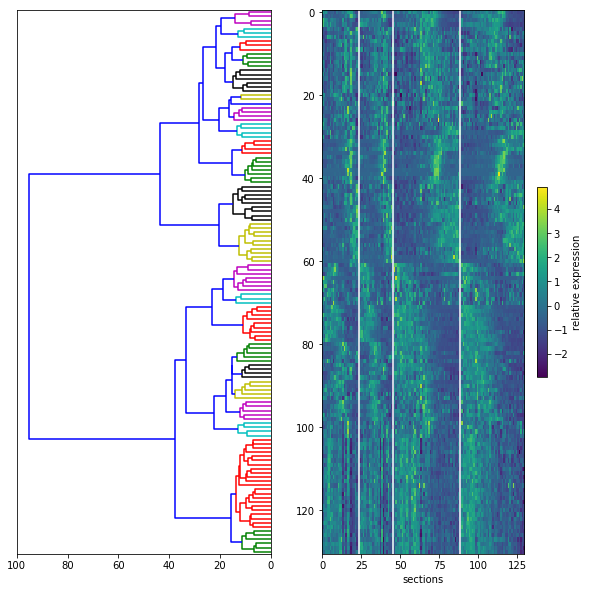

In [92]:
Zall_m, dgall_m = hierarchicalClustering(rnffall_mdf.loc[gsall_ov], ct = 5)

plt.figure(figsize=(10,10))
plt.subplot(121)
dgall_m = dendrogram(Zall_m, no_labels=True, color_threshold=15, orientation='left')
plt.subplot(122)
plt.imshow(rnffall_mdf.loc[gsall_ov[dgall_m['leaves']][::-1]], aspect='auto')
plt.colorbar(shrink=.35, label = 'relative expression', orientation = 'vertical')
plt.xlabel('sections')
plt.axvline(len(rnffchi1.columns)-0.5, c = 'w')
plt.axvline(len(rnffchi1.columns)+len(rnffchi2.columns)-0.5, c = 'w')
plt.axvline(len(rnffchi1.columns)+len(rnffchi2.columns)+len(rnffsb1.columns)-0.5, c = 'w')

plt.savefig('heatmap-all-merged.pdf', bbox_anchor = 'tight')

plt.show()

In [93]:
clustersall_m = getClusterByColor(dgall_m, gsall_ov)

In [94]:
for cluster in clustersall_m:
    pd.Series(clustersall_m[cluster]).to_csv('heatmap-all-merged_hclust' + str(cluster).zfill(3) + '.txt')